# **Machine Learning for Robotics II**

**Classification of FashionMNIST dataset using CNN**

The aim of this project is to perform multi-class classification on MNIST Fashion dataset using Convolution Neural Network (CNN). The neural network is build from scratch using PyTorch library. PyTorch is an environment for programming neural networks with the encapsulated effect that you can use hardware accelerators, such as CUDA. PyTorch is built on top of TensorFlow which is used for distributed machine learning on any platform.

In [ ]:
import torch
import seaborn as sn
import pandas as pd
import numpy as np

**Hardware Accelerator**

Colab allow us to find the cloud device where we can deploy and train our CNN using graphical processing unit (GPU), such as CUDA.

In [ ]:
# device = CUDA, if a device is present, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# If gpu is present then
if torch.cuda.is_available():
  # hardware accelerator
  print(torch.cuda.get_device_name(0))

cuda
Tesla T4


As we can see 'cuda' is available with 'gpu' Tesla T4. 

## **Importing Dataset**

We are using the Fashion MNIST dataset which is available inside the torchvision library. This library allow us to split data into training and testing subsets and transform it into tensor which is a generic n-dimensional array used for arbitrary numeric computation.

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# creating training data with MNIST dataset.
train_data = datasets.FashionMNIST(
  root = 'data',
  train = True,
  transform = ToTensor(),
  download = True
)

# creating testing data
test_data = datasets.FashionMNIST(
  root = 'data',
  train = False,
  transform = ToTensor(),
  download = True
)

Here, we have downloaded the data and split it into training and testing sets. Training set has 60,000 images and testing set has 10,000 images. Each sample has a size of 28x28. Unlike in classical ML examples, we don't vectorize this data and instead keep it in original form because convolution is able to deal directly with images.

# **Class Labels**

In [ ]:
Labels = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
          }

In [ ]:
print(train_data,"\n")
print(train_data.data.size(),"\n")
print(test_data,"\n")
print(test_data.data.size(), "\n")

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 

torch.Size([60000, 28, 28]) 

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor() 

torch.Size([10000, 28, 28]) 



## **Checking data**

**Creating image matrix with their labels.**

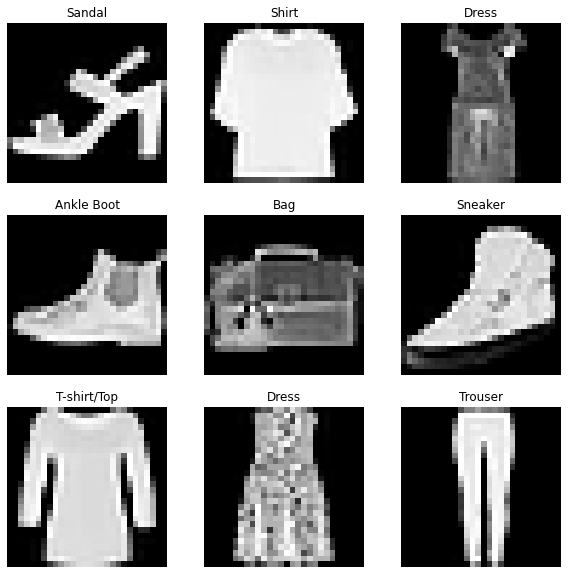

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))
cols, rows = 3, 3
for i in range(1,cols*rows+1):
  j = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[j]
  figure.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title('%s' % Labels[label])
  plt.axis('off')
plt.show()

## **Convolution Neural Network (CNN)**  

After importing training and testing sets and plotting images with their respective labels, we will start building a CNN.

## **Data Loader**

When we deal with neural networks, we usually have huge amounts of data. Huge enough that RAM is insufficient for it. This means that it cannot be loaded in the RAM as we usually do in the case of classical ML. For this reason, we need *DataLoader*. DataLoader basically handles data such that not all of it is stored in RAM but only a part of it. If we have 60,000 samples we can split it into smaller batches of size 100 for convenient storage and processing.  

In [ ]:
# Importing DataLoader Library. 
from torch.utils.data import DataLoader

# Creating dictionary to store dataloaders of training and testing samples. 
loaders = {
    'train' : DataLoader(train_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers= 1),
    'test'  : DataLoader(test_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers= 1)
}

## **Creating a CNN Model**

In case of neural network, the algorithm is actually the structure itself. We first define the shape and architecture of the neural network model. After this, we define the algorithm for training our model using training dataset (for example, gradient descent). After the training phase, we test our model on testing dataset and see the quality of results. 

We don't create the network completely from scratch. Torch environment provide us a network class for neural network construction with all the necessary functionalities. In order to construct a new neural network, we make sure that our network class inherits from this parent class. 


### **CNN Model Class**

Defining CNN model class.

**First Layer: (Conv1)**

**in_channels** are the number of channels our image has that we pass in the convolutional layer as input. In our case, we have 1 channel only since the image is gray.

**out_channels** are the number of channels we want the output of this convolutional layer to have. Usually it's 32 or 64 channels. In our case, it's 32. The more channels you have, the more capable the model is to set aside different kernels and creates different relations between pixels. At the same time, we also need to take into account that with more output channels, our convolutional layer will have more weights, bias and heavier model.  

**Kernel size, stride and padding** will define what will be the size of our output image given the size of input image.

**Kernel (3,3)** means that we will take the kernel window of 3x3 and slide it over the input image.

**Stride (1,1)** means that our kernel will move pixel by pixel without skipping anything in between. 

**Padding (1,1)** means that we will add 1 empty pixel on the edges of the image.

This combination of Kernel(3,3), Stride(1,1) and Padding(1,1) gives **SAME CONVOLUTION** which means that the size of the input image (width and height) is the same as output image.

**Second Layer: (Conv2)**

**in_channels** For second-layer, the input-channels will be equal to the output channel of first-layer which is 32 in our case.   

**out_channels** The output channel will be equal to 64. 

**Kernel (3,3), Stride (1,1), Padding (1,1)** will remain the same as first layer.


**MAX-POOL** with convolutional layers is very useful to utilize the max-pool concept. Max-pool is selects the maximum value from some number of pixels. So it decreases the size of the image and the next convolutional-layer has less weights and bias while the most important information from the image is secured resulting in a lighter model to go forward with.

So, we will have a layer of max-pool with kernel size (2,2) and stride (2,2). The Kernel(2,2) decreases the width and height of the image by half.

**Fully-Connected-Layer** 

We have a fully connected layer with parameters **in_features** which is equal to the linear size of image. In our case, it would be the number of output channels of the second-layer which is 64 and the size of the image after applying max-pooling. After max-pooling, the image will be equal to 1/4 of the original size. So in_feature = (img_w/4)*(img_h/4)*output_channels_2ndlayer

The second parameter is the number of classes which in our case is 10.

In [ ]:
 # Importing the Neural Network library from PyTorch
import torch.nn as nn

# constructing a class CNN (convolutional neural network) which inherits the functionalities from parent class 'nn.Module'
class CNN(nn.Module):

  # Calling the constructor 
  def __init__(self, num_channels=1, num_conv_channels=[32,64], image_h=28,
               image_w=28, num_classes=10):

    super(CNN,self).__init__()

    # We will use 'Conv2d' class of "nn" library for creating convolutional layer.
  
    # Once our convolutional layer is set, we will put activation of type: "ReLU". Since we are using
    # a big neural network, we can't use 'sigmoid' due to gradient vanishing problem. We need to
    # use something that will allow us to propagate the gradient backward in the network. 

    # conv layer 1:
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels, out_channels=num_conv_channels[0],
                           kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(num_conv_channels[0]),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    # conv layer 2:
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=num_conv_channels[0], out_channels=num_conv_channels[1],
                           kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(num_conv_channels[1]),
        nn.ReLU(),
        nn.MaxPool2d(2,2))    
    
    # Now, after this second layer we put a fully connected linear layer at the end.
    # This layer will take the output of the previous layer as input. So, we need to
    # find the size of the output images from second convolutional layer. 
    
    # The size depends on the number of output channels, padding and stride in the previous
    # layer, which is 64, 1 and 1. And also from the kernel size of max pooling in previous
    # layer which is 2. 

    # Here, in our case the size of the output image is 64*7*7. We get 64 from the size of 
    # output channel of the previous layer and we get 7*7 as the size of the image. The size
    # of the image is no longer 28x28 but it is 7x7 because we have applied max-pooling of
    # kernel size 2 twice. So (((28x28)/2)/2)= 7x7.  
        
    # update
    self.out = nn.Linear(num_conv_channels[1]*int(image_w/4)*int(image_h/4), num_classes)

  # FORWARD PROPAGATION
  # Now, since we have all the layer we can define the forward propagation. How these layers are connected together. 
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    # converting a multi-dimensional data into a vector.
    x = x.view(x.size(0),-1)
    x = self.out(x)
    return x


## **Model Testing**

Our CNN class is ready. Now, we will create an object of this class and test it with sample data and check if it is returning the result with a proper structure.

In [ ]:
cnn = CNN()
# 32 images of 1 channel with width = 28 and height = 28.
x = torch.randn(32, 1, 28, 28)
y = cnn(x)
# The shape of the output y have to be 32 which represents the number of samples and 10 which are the number of classes.
print(x.shape)
print(y.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
cnn.to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3136, out_features=10, bias=True)
)


**LOSS FUNCTION OF CNN**

We will use classical loss function for multi-class classification. This is a
differential version of the loss function which tells us the mistakes. Other loss function won't work (labeled correct or labled not correct) because the derivative is zero. So we need to use a loss-function that approximates these in case of multi-class classification. This is the state-of-the-art.

In [ ]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


**OPTIMIZER**

Now, once we have defined the structure of the function and the error to check which are the good parameters for this architecture, we need to define the optimizer.

We use the optimizer "Adam" which is the simplest gradient
descent with an adaptive learning rate. We need to pass the parameters in optimizer which in our case are "cnn.parameters()". We can even choose to optimize individual layers. We also specify the learning rate "lr".  


In [ ]:
# importing optimizer from torch
from torch import optim  

optimizer = optim.Adam(cnn.parameters(),lr = 0.001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


*   **weight_decay** is the regularization of weights to keep the weights small.
*   **eps** is the parameter which decides when to stop going further and when we have reached the minima.

## **Training Loop**

Training loop is an iterative process of learning and re-learning on the same dataset. Each iteration is known as epoch.

We train our model with a batch of the training dataset and then we perform backward-propagation with the same mini-batch in the first epoch. For the next batch, this cycle of forward propagation and back propagation is repeated. Important thing to note here is that the number of images in each batch can impact the efficieny of our model because the number of images in each batch going forward and backward directly correlates with the number of batches.

**LOSS:**

The loss we are calculating here reflects the differences between "prediction_y" (y_hat) and the actual value of the label "y". This difference between y_hat and y is decreased with each iteration in an epoch.

In [ ]:
import tqdm
from torch.autograd import Variable

def train(num_epoch, cnn, loaders):

    # putting our model on training mode.
    cnn.train()
    for epoch in range(num_epoch):
      running_loss = 0
      with tqdm.tqdm(loaders['train'], unit='batch') as tepoch:    
        # For each epoch we go through all the batches in our training dataset. 
        for i, (img, labels) in enumerate(tepoch):
          
          # sending data to device.
          x = Variable(img).to(device)
          y = Variable(labels).to(device)
          
          # forward propagatin:
          output = cnn(x)
          loss = loss_func(output,y)
          running_loss += loss

          #backward propagation:
          optimizer.zero_grad()           # zero_grad() make sure that no gradient carried over from previous calculations.
          loss.backward()                 # setting loss on backward mode.
          optimizer.step()
          tepoch.set_postfix(loss=loss.item())

        print(f'Epoch {epoch}; Loss: {running_loss}')

In [ ]:
# Model Training
NUM_EPOCH = 10
train(NUM_EPOCH,cnn,loaders)

100%|██████████| 600/600 [00:11<00:00, 54.31batch/s, loss=0.281]


Epoch 0; Loss: 238.4254150390625


100%|██████████| 600/600 [00:11<00:00, 53.50batch/s, loss=0.206]


Epoch 1; Loss: 161.41000366210938


100%|██████████| 600/600 [00:11<00:00, 53.91batch/s, loss=0.178]


Epoch 2; Loss: 142.17437744140625


100%|██████████| 600/600 [00:11<00:00, 52.63batch/s, loss=0.241]


Epoch 3; Loss: 125.96809387207031


100%|██████████| 600/600 [00:11<00:00, 53.45batch/s, loss=0.199]


Epoch 4; Loss: 115.82244873046875


100%|██████████| 600/600 [00:11<00:00, 53.69batch/s, loss=0.159]


Epoch 5; Loss: 105.26591491699219


100%|██████████| 600/600 [00:11<00:00, 52.88batch/s, loss=0.107]


Epoch 6; Loss: 99.29763793945312


100%|██████████| 600/600 [00:11<00:00, 52.95batch/s, loss=0.11]


Epoch 7; Loss: 90.35321044921875


100%|██████████| 600/600 [00:11<00:00, 52.85batch/s, loss=0.136]


Epoch 8; Loss: 83.7115707397461


100%|██████████| 600/600 [00:11<00:00, 52.41batch/s, loss=0.154]

Epoch 9; Loss: 79.0379867553711


## **Testing Loop**

The testing loop starts with "with torch.no_grad()" statement which indicates to PyTorch that this is not a training loop. We don't want to perform any  gradient calculation and therefore don't allocate any processing unit for this purpose. We want everything as efficient as possible.



In [ ]:
from sklearn.metrics import confusion_matrix

actual_y_test = []
predicted_y_test = []
# We don't really need to test our model on the device.
cnn.to('cpu')
with torch.no_grad():
  for (images, labels) in loaders['test']:
    
    # forward.
    test_output = cnn(images)
    pred_y = torch.max(test_output,1)[1].data.squeeze()
    actual_y_test += labels.tolist()
    predicted_y_test += pred_y.tolist()


## **Confusion Matrix**

For checking the accuracy of our model we are using confusion matrix.



In [ ]:
cf_matrix=confusion_matrix(actual_y_test,predicted_y_test)
cf_matrix

array([[779,   0,   9,  11,   7,   3, 188,   0,   3,   0],
       [  0, 986,   0,   5,   1,   0,   7,   0,   1,   0],
       [ 13,   1, 744,   8,  88,   0, 146,   0,   0,   0],
       [  8,   2,   6, 899,  30,   0,  55,   0,   0,   0],
       [  1,   0,  13,  23, 889,   0,  74,   0,   0,   0],
       [  0,   0,   0,   0,   0, 987,   0,   9,   0,   4],
       [ 46,   1,  18,  16,  56,   0, 859,   0,   4,   0],
       [  0,   0,   0,   0,   0,  10,   0, 975,   0,  15],
       [  2,   0,   0,   6,   3,   3,   9,   2, 975,   0],
       [  1,   0,   0,   0,   0,   8,   0,  34,   0, 957]])

## **Heatmap**

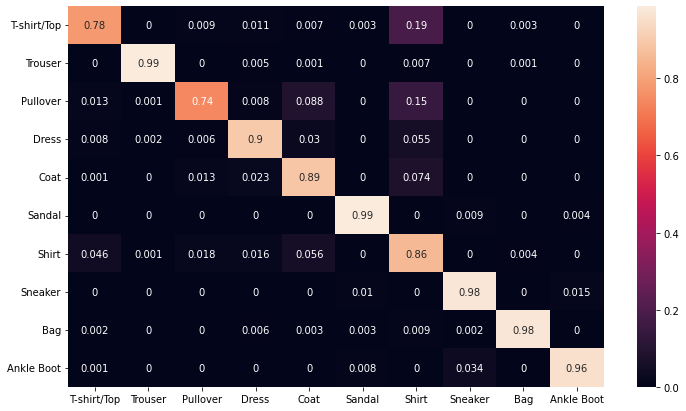

In [ ]:
lable_lst = list(Labels.values())
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*10, index = lable_lst,
                     columns = lable_lst)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(actual_y_test,predicted_y_test,target_names=lable_lst)
print(cr)

              precision    recall  f1-score   support

 T-shirt/Top       0.92      0.78      0.84      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.94      0.74      0.83      1000
       Dress       0.93      0.90      0.91      1000
        Coat       0.83      0.89      0.86      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.64      0.86      0.73      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.97      0.98      1000
  Ankle Boot       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

